# Exploratory Data Analysis of Pharmacological Prescription Data

This notebook performs exploratory data analysis (EDA) on a dataset of pharmacological prescription events. The primary goal is to compute the "event interval" (the difference in days between consecutive medication events for each patient), visualize the empirical cumulative distribution function (ECDF) of these intervals, perform density estimation and clustering using the k-means algorithm, and finally, analyze the duration of filled prescriptions using box plots by prescription order.

This analysis is inspired by the Sessa Empirical Estimator (SEE) approach for computing prescription duration when direct information is missing.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Set seaborn style for consistency
sns.set(style="whitegrid")

This cell imports all required libraries. We use Pandas and NumPy for data manipulation, Matplotlib and Seaborn for visualization, and SciPy and scikit-learn for statistical and clustering methods.

We then load the dataset from the [AdhereR | med.events.ATC](https://search.r-project.org/CRAN/refmans/AdhereR/html/med.events.ATC.html) CSV file, ensuring that the date column is parsed as a datetime object. We then rename the "CATEGORY" column to "ATC" to maintain consistency throughout the analysis.

In [40]:
# Load the dataset and parse dates
med_events_df = pd.read_csv('../data/med_events_ATC.csv', parse_dates=['DATE'])

# Rename the column "CATEGORY" to "ATC" so that our code can filter consistently using 'ATC'
if 'CATEGORY' in med_events_df.columns:
    med_events_df.rename(columns={'CATEGORY': 'ATC'}, inplace=True)
print("Dataset columns:", med_events_df.columns.tolist())

Dataset columns: ['PATIENT_ID', 'DATE', 'DURATION', 'PERDAY', 'ATC', 'CATEGORY_L1', 'CATEGORY_L2']


# Computing Event Interval

This function computes the "event interval" for each patient. It sorts the data by patient and date, computes the date of the previous prescription, and then calculates the difference in days between the current and previous prescriptions.

In [41]:
def compute_event_interval(df):
    """
    For each patient, compute the difference in days between consecutive medication events.
    This "event interval" represents the duration between prescription fills.
    """
    df = df.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    df['prev_DATE'] = df.groupby('PATIENT_ID')['DATE'].shift(1)
    # Remove rows without a previous event (first event for each patient)
    df = df.dropna(subset=['prev_DATE'])
    df['event_interval'] = (df['DATE'] - df['prev_DATE']).dt.days
    return df

# Empirical Cumulative Distribution Function

The `empirical_cdf` function computes the ECDF of a 1D array. The sorted values (x) represent the event intervals, and the y-values represent the cumulative probability, similar to how it's computed in R.

In [42]:
def empirical_cdf(data):
    """
    Compute the empirical cumulative distribution function (ECDF) for a 1D array.
    Returns:
      x : Sorted event intervals in days (equivalent to dfper$x in R)
      y : Cumulative probability (equivalent to dfper$y in R)
    """
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# Optimal K-means Silhouette Function

This function runs the k-means algorithm for a range of cluster numbers and computes the silhouette score for each. It then plots the silhouette scores (with a connecting line) and marks the optimal number of clusters with a dashed vertical line. This analysis helps determine the best value of `k` for clustering our data.

In [43]:
def optimal_kmeans_silhouette(X, k_min=2, k_max=10):
    """
    Determine the optimal number of clusters (k) by computing the silhouette score for each k,
    and plot the average silhouette width vs. k.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The data to cluster.
    k_min : int, optional (default=2)
        Minimum number of clusters to try.
    k_max : int, optional (default=10)
        Maximum number of clusters to try.

    Returns
    -------
    best_k : int
        The k that yields the highest average silhouette score.
    """
    n_samples = X.shape[0]
    if n_samples < 2:
        raise ValueError(f"Not enough samples ({n_samples}) for clustering.")
    # Ensure k_max does not exceed n_samples - 1
    k_max_actual = min(k_max, n_samples - 1)
    k_values = range(k_min, k_max_actual + 1)
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        if len(np.unique(labels)) < 2:
            silhouette_scores.append(-1)
        else:
            try:
                score = silhouette_score(X, labels)
            except Exception as e:
                print(f"Error computing silhouette score for k={k}: {e}")
                score = -1
            silhouette_scores.append(score)
    
    best_k = k_values[np.argmax(silhouette_scores)]

    # Plot silhouette scores with a connecting line
    plt.figure(figsize=(8, 6))
    plt.plot(list(k_values), silhouette_scores, marker='o', linestyle='-')
    plt.axvline(x=best_k, color='blue', linestyle='--')
    plt.title('Optimal number of clusters\nSilhouette Analysis', fontsize=14)
    plt.xlabel('Number of clusters k', fontsize=12)
    plt.ylabel('Average silhouette width', fontsize=12)
    plt.xticks(list(k_values))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return best_k

# Clustering & Processing Data with Optimal K Value

This main function (process_medications) orchestrates the analysis for a given ATC code. It:

- Filters the dataset to the chosen `ATC` code.
- Computes the event interval for each patient.
- Generates ECDF plots (80% and 100%) to visualize the distribution of event intervals.
- Subsets the data to the lower 80% of event intervals (to remove outliers such as extremely long intervals).
- Plots the density of the log-transformed event intervals. The plot is annotated with the sample size (N) and the estimated bandwidth, which are positioned outside the main plot area using `plt.figtext()`.
- Performs clustering on the subset using k-means with an optimal k determined by silhouette analysis.
- Finally, it computes a prescription order (`p_number`) for each patient and creates a box plot of event intervals by `p_number`. In this box plot, the overall median is shown as a red dashed line and the median for each prescription order group is annotated on the plot.

In [44]:
def process_medications(atc_code):
    """
    Process medication events for a specific ATC code.
    Steps:
      1. Filter by ATC code.
      2. Compute the event interval (days between consecutive events).
      3. Plot the 100% and 80% ECDF of the event interval with improved labels.
      4. Subset events to the lower 80% range.
      5. Plot the density of the log-transformed event interval, with N and bandwidth annotated outside the plot.
      6. Determine the optimal number of clusters via silhouette analysis and perform clustering.
      7. Plot a box plot of event intervals (duration) by prescription order (p_number) to mimic the R output.
    """
    # Filter dataset for the desired ATC code
    df_med = med_events_df[med_events_df['ATC'] == atc_code].copy()
    df_med = compute_event_interval(df_med)
    
    # Compute the ECDF for the event_interval (100% ECDF)
    x_ecdf, y_ecdf = empirical_cdf(df_med['event_interval'])
    df_ecdf = pd.DataFrame({'event_interval': x_ecdf, 'cdf': y_ecdf})
    
    # Retain only the lower 80% of the ECDF (i.e., where cdf <= 0.8)
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['event_interval'].max()
    
    print(f"ATC code {atc_code} - Total events: {len(df_ecdf)}, 80% events: {len(df_ecdf_80)}, ni: {ni}")
    
    # Plot 80% ECDF and 100% ECDF side-by-side with improved labels
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Left subplot: 80% ECDF
    axes[0].plot(df_ecdf_80['event_interval'], df_ecdf_80['cdf'], marker='o', linestyle='None')
    axes[0].set_title('80% ECDF of Event Intervals', fontsize=14)
    axes[0].set_xlabel('Event Interval in Days (dfper$x)', fontsize=12)
    axes[0].set_ylabel('Cumulative Probability (dfper$y)', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    # Right subplot: 100% ECDF
    axes[1].plot(df_ecdf['event_interval'], df_ecdf['cdf'], marker='o', linestyle='None')
    axes[1].set_title('100% ECDF of Event Intervals', fontsize=14)
    axes[1].set_xlabel('Event Interval in Days (x)', fontsize=12)
    axes[1].set_ylabel('Cumulative Probability (y)', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Subset data to only include events with interval <= ni (80% range)
    df_subset = df_med[df_med['event_interval'] <= ni].copy()
    if df_subset.empty:
        print("No data in the 80% range. Skipping density and clustering steps.")
        return df_med, pd.DataFrame()
    
    # Plot the density of the log-transformed event interval for the subset
    # Filter out non-positive event intervals (since log(0) is -inf)
    positive_intervals = df_subset['event_interval'][df_subset['event_interval'] > 0]
    if len(positive_intervals) < 2:
        print("Not enough positive event intervals for density estimation. Skipping density plot.")
    else:
        log_intervals = np.log(positive_intervals)
        # Check if the data are nearly constant
        if np.std(log_intervals) < 1e-10:
            print("Log-transformed event intervals are nearly constant. Skipping density plot.")
        else:
            try:
                density = gaussian_kde(log_intervals)
            except np.linalg.LinAlgError as e:
                print("LinAlgError encountered in gaussian_kde. Skipping density plot.")
            else:
                x_density = np.linspace(log_intervals.min(), log_intervals.max(), 200)
                y_density = density(x_density)
                # Compute bandwidth similar to R's default approach
                bandwidth = density.factor * log_intervals.std(ddof=1)
                n_points = len(log_intervals)
                
                plt.figure(figsize=(5, 8))  # Tall, narrow figure
                plt.plot(x_density, y_density, color='blue')
                # Add axis labels
                plt.title('Log(event interval)', fontsize=14)
                plt.xlabel('Log(Event Interval)', fontsize=12)
                plt.ylabel('Density', fontsize=12)
                # Place "N = xx   Bandwidth = xx" outside the plot using figtext
                text_str = f'N = {n_points}   Bandwidth = {bandwidth:.4f}'
                plt.figtext(0.5, 0.01, text_str, ha='center', fontsize=12)
                plt.show()

    # Prepare data for clustering (using event_interval from the subset)
    scaler = StandardScaler()
    X = scaler.fit_transform(df_subset[['event_interval']])
    if len(X) < 2:
        print("Not enough data for clustering. Skipping clustering step.")
        cluster_summary = pd.DataFrame()
    else:
        optimal_k = optimal_kmeans_silhouette(X)
        print(f"Optimal number of clusters for ATC code {atc_code}: {optimal_k}")
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        df_subset['Cluster'] = kmeans.fit_predict(X)
        cluster_summary = df_subset.groupby('Cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    
    # Instead of plotting by Cluster, plot a box plot of duration (event_interval) by prescription order (p_number)
    # Compute prescription order (p_number) for each patient
    df_sorted = df_med.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    # Exclude the first event (p_number=1) since event_interval is computed from the second event onward
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x='p_number', y='event_interval', data=df_filtered)
    plt.xticks(rotation=90)
    overall_median = df_filtered['event_interval'].median()
    plt.axhline(y=overall_median, color='red', linestyle='--', label='Overall Median')
    # Annotate each group's median on the plot
    medians = df_filtered.groupby('p_number')['event_interval'].median()
    for i, median_val in enumerate(medians):
        ax.text(i, median_val, f'{median_val:.1f}', horizontalalignment='center',
                verticalalignment='bottom', color='blue', fontsize=10)
    plt.legend()
    plt.title('Boxplot of Duration (Event Interval) by PATIENT_ID (p_number)', fontsize=14)
    plt.xlabel('PATIENT_ID (p_number)', fontsize=12)
    plt.ylabel('Duration (days)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return df_med, cluster_summary

# Analysis of Chosen ATC Code

This cell executes the analysis pipeline for a chosen ATC code. The outputs include ECDF plots, a density plot of the log-transformed event intervals (with sample size and bandwidth annotated below the plot), and a box plot of the event intervals by prescription order with group medians annotated.

We can swap out the ATC code being processed to any valid `CATEGORY` value in our original data set. Likewise, we can loop through every possible category and generate reports from them.

For now, we'll use `J01FA10` as a demo of the graphs we're able to generate based on our SEE algorithm.

ATC code J01FA10 - Total events: 112, 80% events: 89, ni: 42
Optimal number of clusters for ATC code J01FA10: 2


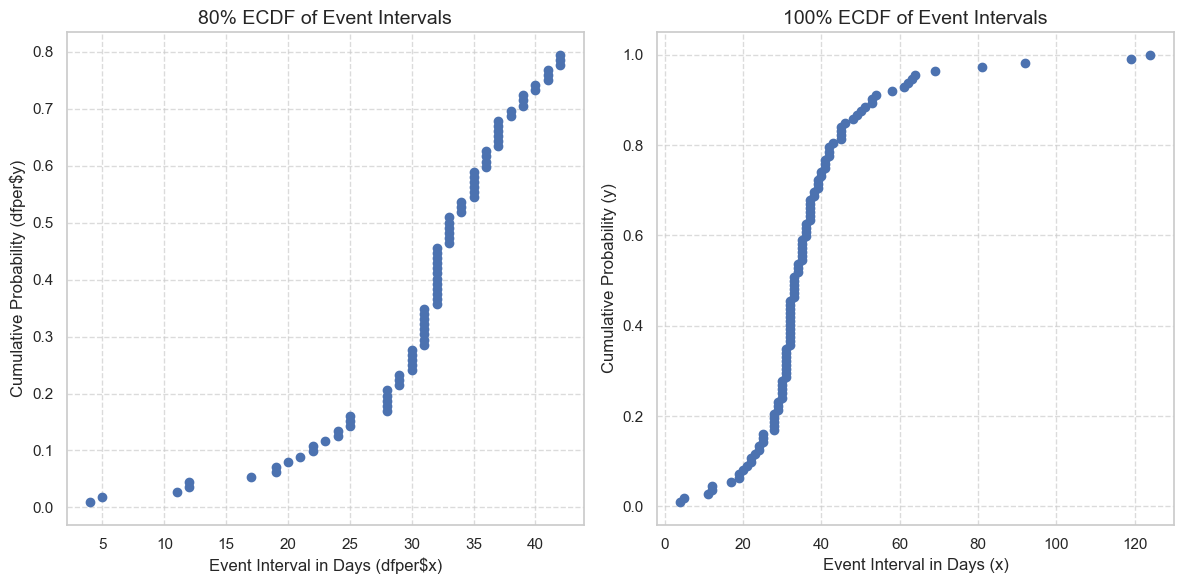

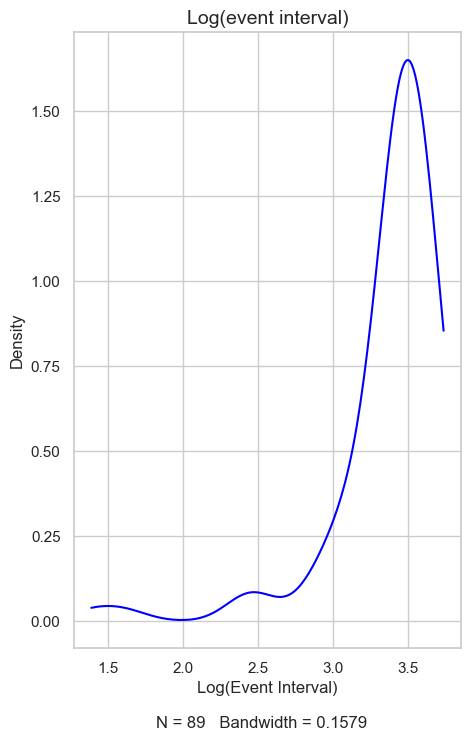

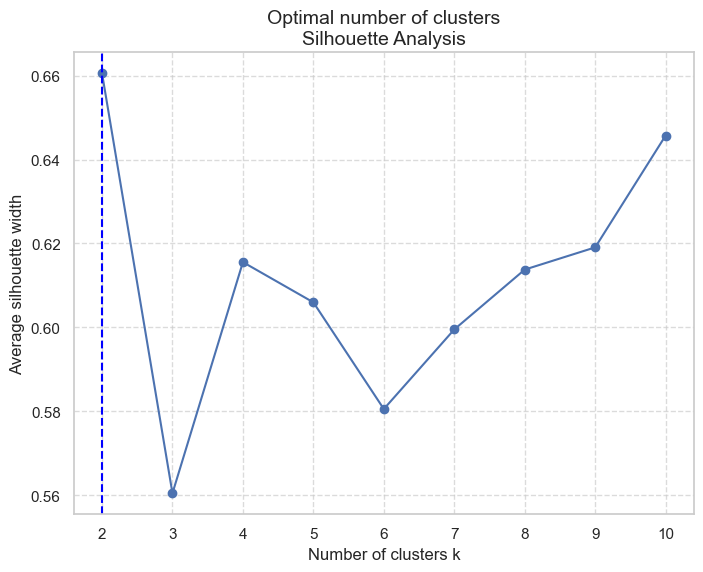

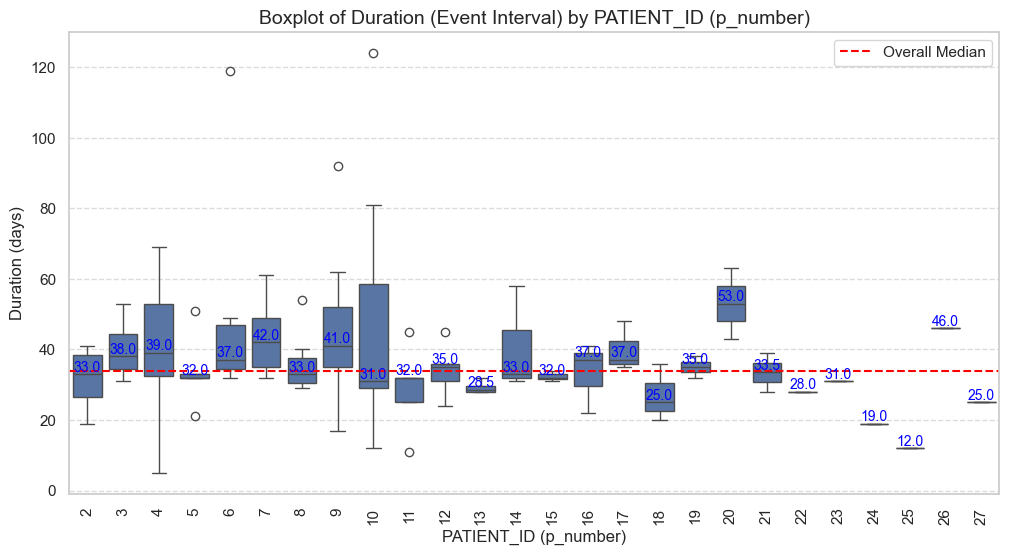

In [45]:
medA_df, medA_clusters = process_medications('J01FA10')

# Generate a PDF Report for All ATC Categories

In this section, we loop through every unique ATC code in our dataset, run the full analysis pipeline (which includes generating ECDF plots, density plots, clustering, and a box plot by prescription order), and then save all the resulting figures into a single PDF report.

For each ATC category:
- A heading page is created with the category name.
- All plots generated by the analysis pipeline for that category are captured.
- The PDF file is then saved for review.

This allows us to quickly generate a comprehensive report of our exploratory data analysis across all available categories.

In [ ]:
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Suppress all warnings
warnings.filterwarnings("ignore")

# Turn interactive plotting off so no figures are displayed
plt.ioff()

# Override plt.show() so figures do not display immediately during PDF creation
old_show = plt.show
plt.show = lambda: None

# Get unique ATC values from the dataset
categories = med_events_df['ATC'].unique()

pdf_filename = '../out/collated_k_means_plots.pdf'
with PdfPages(pdf_filename) as pdf:
    for cat in categories:
        # Create a heading page for the current category
        fig_heading = plt.figure(figsize=(8, 1))
        plt.text(0.5, 0.5, f'Category: {cat}', horizontalalignment='center',
                 verticalalignment='center', fontsize=16)
        plt.axis('off')
        pdf.savefig(fig_heading)
        plt.close(fig_heading)
        
        # Clear any previous figures
        plt.close('all')
        
        # Run the analysis pipeline for the current category in a try/except block
        try:
            df_out, cluster_summary = process_medications(cat)
        except Exception as e:
            print(f"Error processing category {cat}: {e}")
            continue
        
        # Capture and save all figures generated by the process_medications function.
        fig_nums = plt.get_fignums()
        for num in fig_nums:
            try:
                fig = plt.figure(num)
                pdf.savefig(fig)
                plt.close(fig)
            except Exception as e:
                print(f"Error saving figure {num} for category {cat}: {e}")
                continue

# Restore plt.show to its original function and re-enable interactive mode
plt.show = old_show
plt.ion()

print(f"PDF with all category plots saved as {pdf_filename}")

ATC code A02BC02 - Total events: 2, 80% events: 1, ni: 36
Not enough positive event intervals for density estimation. Skipping density plot.
Not enough data for clustering. Skipping clustering step.
ATC code A09AA02 - Total events: 237, 80% events: 189, ni: 42
Optimal number of clusters for ATC code A09AA02: 2
ATC code R03AC12 - Total events: 17, 80% events: 13, ni: 83
Optimal number of clusters for ATC code R03AC12: 3
ATC code A11CC05 - Total events: 95, 80% events: 76, ni: 97
Optimal number of clusters for ATC code A11CC05: 2
ATC code R03AK07 - Total events: 27, 80% events: 21, ni: 90
Optimal number of clusters for ATC code R03AK07: 3
ATC code A05AA02 - Total events: 70, 80% events: 56, ni: 40
Optimal number of clusters for ATC code A05AA02: 10
ATC code A11CA01 - Total events: 19, 80% events: 15, ni: 103
Optimal number of clusters for ATC code A11CA01: 3
ATC code A11HA03 - Total events: 150, 80% events: 120, ni: 51
Optimal number of clusters for ATC code A11HA03: 10
ATC code A12AX - 

# Conclusions and Next Steps

The exploratory data analysis of the pharmacological prescription dataset provided several important insights:

### ECDF Analysis
The 80% ECDF plots effectively reduce the influence of extreme refill intervals (outliers) and highlight the core distribution of inter-prescription durations. However, in cases where only a few events are recorded (e.g., very sparse data), the SEE algorithm’s reliability is compromised, as evidenced by categories with minimal events.

### Density Plots of Log-Transformed Event Intervals
The density plots offer a smooth visualization of the underlying distribution of log-transformed event intervals. The annotations for sample size (N) and estimated bandwidth are valuable for interpreting the data’s spread. Notably, insufficient positive event intervals precluded reliable density estimation in some categories, underscoring a limitation of the method when sample sizes are low.

### Clustering Analysis
Silhouette analysis was used to determine the optimal number of clusters, which aids in classifying refill patterns. While the approach is robust in larger datasets, the clustering performance deteriorates in categories with sparse data. This limitation indicates that the SEE algorithm may not provide reliable duration estimates when the dataset lacks sufficient refill events.

### Box Plots by Prescription Order
Box plots of event intervals by prescription order (p_number) reveal trends in patient refill behavior over time. The annotated group medians and overall median help to assess changes in adherence or treatment patterns as the prescription order increases. Variations in these medians across groups suggest potential shifts in patient behavior or dosing patterns over the treatment course.

## Limitations and Future Directions

### Data Insufficiency
The SEE algorithm's performance is sensitive to sample size. For several ATC categories with limited refill events, the analysis was inconclusive. Future work should explore data augmentation strategies or alternative methods when confronted with sparse data.

### Algorithm Validation
Further validation of the SEE against researcher-defined duration (RDD) methods is necessary. Comparative analyses—including sensitivity, specificity, and precision assessments—should be conducted using both simulated and real-world datasets to ensure the robustness of the SEE algorithm.

### Extended Analyses
Future studies may benefit from integrating additional clinical and demographic variables to understand how refill patterns correlate with patient characteristics and outcomes. Such multifactorial analyses could enhance the utility of the SEE method in pharmacoepidemiologic research.

---

While the SEE algorithm shows promise in estimating prescription durations from refill data, its reliability depends on having sufficient data. Enhancing data collection, exploring alternative modeling approaches for sparse datasets, and validating the method across diverse populations remain important next steps.